# Анализ тональности

# Содержание
1. [Импорт библиотек](#Импорт-библиотек)
2. [Загрузка данных](#Загрузка-данных)
3. [Предобработка](#Предобработка)
5. [Обучение](#Обучение)
6. [Выводы](#Выводы)


**Цель проекта** - обучить модель классифицировать отзывы на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. 


**Задачи проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


**Описание данных**

В нашем распоряжении набор данных с разметкой об эмоциональной окраске отзывов о банках. Данные находятся в файле `data.csv`. Столбец *text* в нём содержит текст отзыва, а *coloring* — целевой признак.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
from collections import defaultdict

nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import optuna

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\js\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных

In [2]:
server_path = '' 
local_path= 'C:/Users/js/OneDrive/Рабочий стол/мл'               
data = 'data.csv'

try:
    data = pd.read_csv(server_path + data, index_col=0)  
except: 
    data = pd.read_csv(local_path + data, index_col=0)  


In [3]:
df = data[data['text'].notnull()]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9896 entries, 0 to 9898
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        9896 non-null   object
 1   text       9896 non-null   object
 2   date       9896 non-null   object
 3   city       9896 non-null   object
 4   bank_name  9781 non-null   object
 5   theme      9896 non-null   object
 6   coloring   9896 non-null   object
dtypes: object(7)
memory usage: 618.5+ KB


In [5]:
df[df['bank_name'].isnull()]

,url,text,date,city,bank_name,theme,coloring
47,https://www.banki.ru/services/responses/bank/r...,"Заказал карту, 09.08 курьер привз точно в срок...",2024-08-16 15:28:00,Новокузнецк (Кемеровская область),NaN,Не могут активировать карту,neg
72,https://www.banki.ru/services/responses/bank/r...,Жалоба. 29.08.2024 г. Я обратился на горячую л...,2024-08-29 14:58:00,Ульяновск (Ульяновская область),NaN,Отвратительный банк с некомпетентными работниками,neg
104,https://www.banki.ru/services/responses/bank/r...,У меня была подписка тинькофф про с поавшенным...,2024-02-08 03:20:00,Самара (Самарская область),NaN,Принудительное изменение условий без уведомлен...,neg
291,https://www.banki.ru/services/responses/bank/r...,В воскресенье 8.09 вывела СВОИ деньги с баланс...,2024-11-09 09:44:00,Вологда (Вологодская область),NaN,"Поддержка не отвечает, никто делать ничего не ...",neg
301,https://www.banki.ru/services/responses/bank/r...,НИКОМУ И НИКОГДА В ЖИЗНИ Я НЕ ПОСОВЕТУЮ ЭТОТ Б...,2024-08-09 22:26:00,Москва,NaN,"Это не банк, а какой-то кошмар",neg
...,...,...,...,...,...,...,...
9479,https://www.banki.ru/services/responses/bank/r...,"Добрый день, читатель.Есть у меня несколько ка...",2024-08-16 12:22:00,Москва,NaN,Не выплачивают обещанный персонально кэшбэк,neg
9602,https://www.banki.ru/services/responses/bank/r...,"Попытка расплатиться бонусами СберСпасибо, это...",2024-11-09 13:55:00,Москва,NaN,"Ну, не с первого раза, и даже не с десятого",neg
9623,https://www.banki.ru/services/responses/bank/r...,"Разочарована в данном банке. Ушла от них, но у...",2024-07-08 14:40:00,Набережные Челны (Республика Татарстан),NaN,Такой себе,neg
9731,https://www.banki.ru/services/responses/bank/r...,Теперь ИТБ присоединился к обману. Сначала бан...,2024-12-09 20:40:00,Владимир (Владимирская область),NaN,Одна с ТКБ контора,neg


Обнаружены пропуски и неверный тип данных в 'date', но столбцы будут удалены при обучении модели, обрабатывать нет необходимости.

In [6]:
data['coloring'].value_counts()

coloring
pos    4950
neg    4947
Name: count, dtype: int64

In [7]:
data.duplicated().sum() 

0

## Предобработка

In [8]:
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

In [9]:
def preproc(text):
    text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text) # Заменяем все символы, кроме русских букв и пробелов, на пробелы
    text = text.lower()   # Приводим текст к нижнему регистру
    tokens = nltk.word_tokenize(text, language='russian') #Токенизация
    text = [word for word in tokens if word not in stop_words] #Удаление стоп-слов
    text = [morph.parse(word)[0].normal_form for word in text]  #Лемматизация
    text = ' '.join(text)
    return text

In [10]:
df['processed_texts'] = df['text'].apply(preproc)

In [11]:
[i for i in df['processed_texts']]

['обратиться проблема списание деньга подписка который оформлять цель безопасность сразу предложить заблокировать карта быстро решить возникнуть проблема сотрудник уточнить деталь произойти ситуация оформить заявка возврат средство начислить счёт следующий день перевыпустить мой дебетовый карта спасибо большой быстрый решение проблема',
 'хотеть поблагодарить сотрудник ву анна который помочь онлайн чат решить проблема остаться клиент банк подключить акция получение промый код магазин партнёр банк однако условие акция оказаться непонятный совешение покупка магазин списать балл кэшбэк авансом вперёд считать это правильный акция составить запутанно оказаться данный интернет магазин осуществлять платеий доставка платный возврат товар сотрудник ва анна разобраться мой проблема вернуть списать балл что очень рада очередь попросить банк вернуть акция промокод компенсация балл покупка магазин партнёр банк',
 'столкнуться проблема начало июль открыть вклад мкб финуслуга конец июль позвонить бан

Заменим признак `coloring` на `toxic`, где 1 - это негативный отзыв, 0 - положительный и удалим ненужные столбцы.

In [12]:
data = df.copy()

In [13]:
data['toxic'] = df.apply(lambda row: 1 if row['coloring'] == 'neg' else (0 if row['coloring'] == 'pos'  else None), axis=1)

In [14]:
data = data[['processed_texts', 'toxic']]

Разделим датасет на тренировочную, тестовую и валидационную выборки

In [15]:
train, test = train_test_split(data,
                        test_size = 0.3,
                        random_state = 12348,
                       stratify = data['toxic'])
valid, test = train_test_split(test,
                        test_size = 0.5,
                        random_state = 12348,
                       stratify = test['toxic'])

print(train.shape)
print(valid.shape)
print(test.shape)

(6927, 2)
(1484, 2)
(1485, 2)


Векторизуем текст

In [16]:
tfidf = TfidfVectorizer()

In [17]:
tfidf_train = tfidf.fit_transform(train['processed_texts'])
tfidf_valid = tfidf.transform(valid['processed_texts'])
tfidf_test = tfidf.transform(test['processed_texts'])

In [18]:
tfidf_train.shape

(6927, 20817)

In [19]:
tfidf_test.shape

(1485, 20817)

In [20]:
tfidf_valid.shape

(1484, 20817)

## Обучение

Сравним работу трех моделей по выбранной мере f1.

In [21]:
model = lgb.LGBMClassifier(n_jobs=-1, random_state = 42)
model.fit(tfidf_train, train['toxic'])
pred = model.predict(tfidf_valid)


[LightGBM] [Info] Number of positive: 3463, number of negative: 3464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109541
[LightGBM] [Info] Number of data points in the train set: 6927, number of used features: 2361
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499928 -> initscore=-0.000289
[LightGBM] [Info] Start training from score -0.000289


In [22]:
f1 = f1_score(pred, valid['toxic'])
print('f-1:', f1)

f-1: 0.9685197588747488


In [23]:
model = CatBoostClassifier(early_stopping_rounds = 100, loss_function= 'Logloss', random_state = 42)
model.fit(tfidf_train, train['toxic'])
pred = model.predict(tfidf_valid)
f1 = f1_score(pred, valid['toxic'])
print('f-1:', f1)

Learning rate set to 0.023542
0:	learn: 0.6752857	total: 401ms	remaining: 6m 40s
1:	learn: 0.6589031	total: 706ms	remaining: 5m 52s
2:	learn: 0.6422357	total: 1.01s	remaining: 5m 35s
3:	learn: 0.6257386	total: 1.29s	remaining: 5m 21s
4:	learn: 0.6104327	total: 1.6s	remaining: 5m 17s
5:	learn: 0.5967965	total: 1.87s	remaining: 5m 9s
6:	learn: 0.5839884	total: 2.13s	remaining: 5m 1s
7:	learn: 0.5719377	total: 2.39s	remaining: 4m 56s
8:	learn: 0.5594684	total: 2.68s	remaining: 4m 55s
9:	learn: 0.5491599	total: 2.94s	remaining: 4m 51s
10:	learn: 0.5383022	total: 3.27s	remaining: 4m 53s
11:	learn: 0.5277090	total: 3.58s	remaining: 4m 54s
12:	learn: 0.5183865	total: 3.92s	remaining: 4m 57s
13:	learn: 0.5087129	total: 4.22s	remaining: 4m 57s
14:	learn: 0.4987077	total: 4.52s	remaining: 4m 56s
15:	learn: 0.4893910	total: 4.76s	remaining: 4m 52s
16:	learn: 0.4807942	total: 5.05s	remaining: 4m 52s
17:	learn: 0.4731360	total: 5.38s	remaining: 4m 53s
18:	learn: 0.4660473	total: 5.66s	remaining: 4m

In [24]:
lr = LogisticRegression(multi_class='ovr', class_weight='balanced', max_iter=10000)
lr.fit(tfidf_train, train['toxic'])
pred_train, pred_valid = lr.predict(tfidf_train), lr.predict(tfidf_valid)

In [25]:
print('f-1:', f1_score(valid['toxic'], pred_valid))

f-1: 0.9693741677762983


Логистическая регрессия справляется с задачей лучше, с f1=0.969. Подберем параметры для lr.

In [26]:
def objective_logistic_regression(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', None]),
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    model = LogisticRegression(random_state=42, **param)
    model.fit(tfidf_train, train['toxic'])
    pred_valid = model.predict(tfidf_valid)
    
    f1 = f1_score(valid['toxic'], pred_valid)
    
    return f1

In [27]:
%%time
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_logistic_regression, n_trials=500, timeout=600, n_jobs=-1)


[I 2024-09-25 14:12:55,984] A new study created in memory with name: no-name-0173ff0c-85e9-480c-a5b7-cca61d8268f6
[I 2024-09-25 14:12:56,485] Trial 4 finished with value: 0.9382213170400543 and parameters: {'penalty': 'l2', 'C': 0.00011393473301499453, 'max_iter': 414, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 4 with value: 0.9382213170400543.
[I 2024-09-25 14:12:56,548] Trial 2 finished with value: 0.9463931171409663 and parameters: {'penalty': 'l2', 'C': 0.000895944756070322, 'max_iter': 282, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 2 with value: 0.9463931171409663.
[I 2024-09-25 14:12:56,718] Trial 3 finished with value: 0.9452867501647989 and parameters: {'penalty': 'l2', 'C': 0.0058541937990525756, 'max_iter': 275, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9463931171409663.
[I 2024-09-25 14:12:56,939] Trial 1 finished with value: 0.945910290237467 and parameters: {'penalty': 'l2', 'C': 0.0049726718376484486, 'max_ite

CPU times: total: 31min 12s
Wall time: 5min 45s


In [28]:
print('f-1:',study_lr.best_value)
p = study_lr.best_params
print(p)

f-1: 0.9732977303070761
{'penalty': 'l2', 'C': 21.83780460783186, 'max_iter': 756, 'solver': 'lbfgs', 'class_weight': None}


Проверим на тестовой выборке.

In [29]:
lr = LogisticRegression(penalty='l2', C=13.241164903128972, solver='lbfgs', class_weight='balanced', max_iter=629)
lr.fit(tfidf_train, train['toxic'])
pred_test = lr.predict(tfidf_test)
f1 = f1_score(test['toxic'], pred_test)

In [30]:
print('f-1:',f1)

f-1: 0.9726118904475618


In [31]:
pred_prob = lr.predict_proba(tfidf_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(test['toxic'], pred_prob)  
roc_auc = auc(fpr, tpr) 

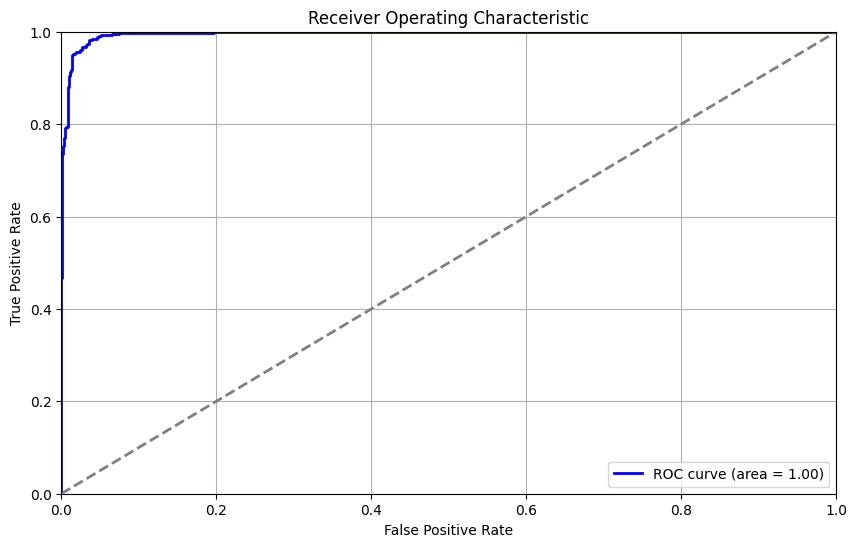

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Линия случайного выбора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

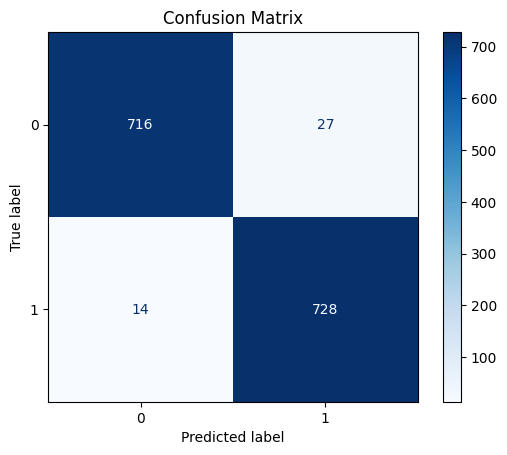

In [33]:
cm = confusion_matrix(test['toxic'], pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Выводы

Для задачи классификации отзывов о банках лучше всего подошла модель логистической регрессии с подобранными параметрами 'penalty', 'C', 'max_iter', 'solver', 'class_weight'. Значение меры `f1` на тестовой выборке равно 0.973, результат хороший.